In [1]:
# коллабные импорты
from google.colab import drive
from google.colab import files

In [2]:
drive.mount('/GD',force_remount=True)

Mounted at /GD


In [3]:
!cp -r /GD/'My Drive'/pics.zip .
!cp -r /GD/'My Drive'/masks.csv .
!cp -r /GD/'My Drive'/my_metric.py .

In [4]:
!mkdir masks

In [ ]:
!unzip pics.zip

In [6]:
import math
import sys
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2

from my_metric import iou

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split

In [7]:
# Загружаем датафрэйм с разметкой
# имена файлов-картинок в список
df = pd.read_csv('masks.csv')

In [8]:
df.head()

,filename,width,height,clas,xmin,ymin,xmax,ymax
0,photo_17266@14-12-2021_09-17-27.jpg,1920,1080,number_plate,233,417,448,487
1,photo_17266@14-12-2021_09-17-27.jpg,1920,1080,number_plate,1594,234,1787,293
2,photo_17281@14-12-2021_09-36-26.jpg,1920,1080,number_plate,394,444,572,491
3,photo_17281@14-12-2021_09-36-26.jpg,1920,1080,number_plate,1593,237,1788,295
4,photo_17297@14-12-2021_10-16-11.jpg,1920,1080,number_plate,418,346,603,390


In [9]:
def get_mask_from_file(filename):
  
    dff = df[df.filename == filename]
    Y = min(dff['height'])
    X = min(dff['width'])
    ms = np.zeros((Y,X,1))
    
    for i in range(dff.shape[0]):
        ms[dff.iloc[i].ymin:dff.iloc[i].ymax,  dff.iloc[i].xmin:dff.iloc[i].xmax] = 1
    
    Y, X = None, None
    
    return ms

In [10]:
filenames = os.listdir('pics')
anno_filenames = df.filename.tolist()

In [11]:
for filename in filenames:
    
    if filename in anno_filenames:
        ms = get_mask_from_file(filename)
    else:
        image = Image.open('pics/' + filename)
        X, Y = image.size
        ms = np.zeros((Y, X, 1))

    ms = (ms * 255).astype(np.uint8)
    ms = np.squeeze(ms)
    image = Image.fromarray(ms)
    image.save('masks/' + filename)

In [12]:
filename = filenames[-1]

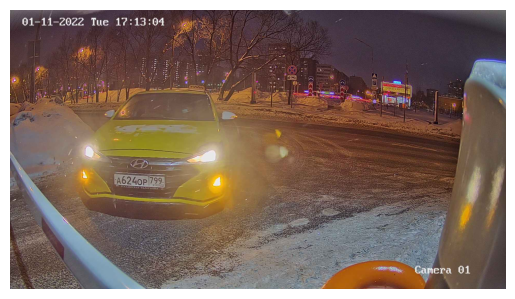

In [13]:
image = Image.open('pics/' + filename)
plt.imshow(image)
plt.axis('off')
plt.show()

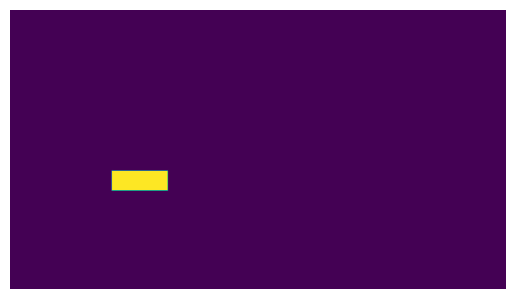

In [14]:
image = Image.open('masks/' + filename)
plt.imshow(image)
plt.axis('off')
plt.show()

In [15]:
# Поделим изображения на train-test выборки.
!mkdir pics_to_train
!mkdir pics_to_test
!mkdir masks_to_train
!mkdir masks_to_test

In [16]:
pics_source_path = 'pics'
masks_source_path = 'masks'

train_path = '_to_train'
test_path = '_to_test'

test_size = 0.2

train_files, test_files = train_test_split(filenames, test_size=test_size,
                                           random_state=0)

In [17]:
for dir in (pics_source_path, masks_source_path):
    for filename in train_files:
        source_file = os.path.join(dir, filename)
        target_file = os.path.join(dir + train_path, filename)
        shutil.copyfile(source_file, target_file)

for dir in (pics_source_path, masks_source_path):
    for filename in test_files:
        source_file = os.path.join(dir, filename)
        target_file = os.path.join(dir + test_path, filename)
        shutil.copyfile(source_file, target_file)

In [19]:
# Размер изображений
Y = 480
X = 640

In [20]:
data_gen_args = dict(rescale=1./255,)
                    # rotation_range=10,
                    # width_shift_range=0.15,
                    # height_shift_range=0.15,
                    # shear_range=0.15,
                    # zoom_range=0.1,
                    # horizontal_flip=False,
                    # fill_mode='nearest')

flow_args = dict(classes=[''],
                 target_size = (Y, X),
                 batch_size = 8,
                 class_mode=None,
                 shuffle=False,)

pics_train_datagen = ImageDataGenerator(**data_gen_args)
masks_train_datagen = ImageDataGenerator(**data_gen_args)
pics_test_datagen = ImageDataGenerator(**data_gen_args)
masks_test_datagen = ImageDataGenerator(**data_gen_args)
    
pics_train_datagen = pics_train_datagen.flow_from_directory('pics_to_train',
                                                            **flow_args)
masks_train_datagen = masks_train_datagen.flow_from_directory('masks_to_train',
                                                              color_mode='grayscale',
                                                              **flow_args)
pics_test_datagen = pics_test_datagen.flow_from_directory('pics_to_test',
                                                          **flow_args)
masks_test_datagen = masks_test_datagen.flow_from_directory('masks_to_test',
                                                            color_mode='grayscale',
                                                           **flow_args)

Found 3100 images belonging to 1 classes.
Found 3100 images belonging to 1 classes.
Found 775 images belonging to 1 classes.
Found 775 images belonging to 1 classes.


In [21]:
train_generator = zip(pics_train_datagen,
                      masks_train_datagen)

In [22]:
test_generator = zip(pics_test_datagen,
                      masks_test_datagen)

In [ ]:
# for pics, masks in train_generator:
#     print(f"Batch shape - pics: {pics.shape}, masks: {masks.shape}")

In [ ]:
# Unet
inputs = Input(shape = (Y, X, 3))

conv1_1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
conv1_2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv1_1)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1_2)

conv2_1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
conv2_2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv2_1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2_2)

conv3_1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
conv3_2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv3_1)
pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3_2)

conv4_1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
conv4_2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4_1)
pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4_2)


up1 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(pool4)
conc_1 = layers.Concatenate()([conv4_2, up1])
conv_up_1_1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conc_1)
conv_up_1_2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv_up_1_1)

up2 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(conv_up_1_2)
conc_2 = layers.Concatenate()([conv3_2, up2])
conv_up_2_1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conc_2)
conv_up_2_2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv_up_2_1)

up3 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(conv_up_2_2)
conc_3 = layers.Concatenate()([conv2_2, up3])
conv_up_3_1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conc_3)
conv_up_3_2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv_up_3_1)

up4 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(conv_up_3_2)
conc_4 = layers.Concatenate()([conv1_2, up4])
conv_up_4_1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conc_4)
conv_up_4_2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv_up_4_1)

result = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv_up_4_2)

model = models.Model(inputs=inputs, outputs=result)

model.compile(loss = 'binary_crossentropy',
             optimizer=optimizers.Adam(learning_rate=0.001), metrics = [iou])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 480, 640, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 480, 640, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
callbacks = [EarlyStopping(monitor='loss',
                           patience=3),
             ModelCheckpoint('detection_net.h5',
                             monitor='iou',
                             verbose=1,
                             save_best_only=True,
                             mode='max')]

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_files)//flow_args['batch_size'],
                    epochs=30,
                    validation_data=test_generator,
                    validation_steps=len(test_files)//flow_args['batch_size'],
                    callbacks=callbacks)

Дообучим модель еще на 30 эпохах.

In [24]:
!cp -r /GD/'My Drive'/detection_net.h5 .

In [27]:
model = tf.keras.models.load_model('detection_net.h5', compile=False)

model.compile(loss = 'binary_crossentropy',
             optimizer=optimizers.Adam(learning_rate=0.001), metrics = [iou])

In [28]:
callbacks = [EarlyStopping(monitor='loss',
                           patience=3),
             ModelCheckpoint('detection_net.h5',
                             monitor='iou',
                             verbose=1,
                             save_best_only=True,
                             mode='max')]

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_files)//flow_args['batch_size'],
                    epochs=30,
                    validation_data=test_generator,
                    validation_steps=len(test_files)//flow_args['batch_size'],
                    callbacks=callbacks)

История обучения в файле history.txt

In [30]:
!cp detection_net.h5 /GD/'My Drive'/detection_net.h5